# Testing the Limits of Pre-training

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# %env PYTHONPATH="../"
sys.path.append('../')

In [4]:
PATH = '../../scratch/aorl/e2e_maze_8_2/e2e_maze_8_2.a5406616b3951230fafa4ca948138750f5881270649f6138153e795abde02629'
RUN_NAME = 'e2e_maze_8_2.a5406616b3951230fafa4ca948138750f5881270649f6138153e795abde02629'
PROJECT_NAME = 'aorl'

## Get W&B Information

In [5]:
import wandb

api = wandb.Api()
# wandb.login(key='wandb_v1_Ly3eFqIQrxItHDUO00wHBVWktDM')

In [6]:
ENTITY = 'jnzhao3'

run = api.runs(f'{ENTITY}/{PROJECT_NAME}', filters={'display_name': f'{RUN_NAME}'})[0]

In [7]:
run.config['seed']

3

## Load the Originally Trained Agent

In [8]:
from utils.flax_utils import restore_agent, save_agent
from agents import agents

In [9]:
from agents.gcfql import get_config

In [10]:
run.config['agent']

{'lr': 0.0003,
 'tau': 0.005,
 'alpha': 300,
 'q_agg': 'mean',
 'num_qs': 10,
 'ob_dims': None,
 'discount': 0.995,
 'action_dim': None,
 'actor_type': 'best-of-n',
 'agent_name': 'gcfql',
 'batch_size': 256,
 'flow_steps': 10,
 'layer_norm': True,
 'awr_invtemp': 0,
 'gc_negative': False,
 'num_actions': 8,
 'dataset_class': 'GCDataset',
 'subgoal_steps': 25,
 'actor_p_curgoal': 0,
 'value_p_curgoal': 0.2,
 'actor_p_trajgoal': 0.5,
 'critic_loss_type': 'bce',
 'value_p_trajgoal': 0.5,
 'actor_geom_sample': True,
 'actor_hidden_dims': [512, 512, 512, 512],
 'value_geom_sample': False,
 'value_hidden_dims': [512, 512, 512, 512],
 'actor_p_randomgoal': 0.5,
 'goal_proposer_type': 'awr',
 'value_p_randomgoal': 0.3,
 'train_goal_proposer': False}

In [11]:
# config = get_config()
config = run.config['agent']

In [12]:
agent_class = agents[config['agent_name']]

In [13]:
from utils.datasets import GCDataset, Dataset
import pathlib
from wrappers.datafuncs_utils import make_env_and_datasets

DATA_STEP = 3000000

dataset_path = pathlib.Path(PATH) / f'data-{DATA_STEP}.npz'
env, train_dataset, val_dataset = make_env_and_datasets(run.config['env_name'], dataset_path=str(dataset_path), use_oracle_reps=True)
dataset_class = GCDataset
train_dataset = dataset_class(Dataset.create(**train_dataset, freeze=False), config)

/home/jennifer/miniconda3/envs/aorl/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
/home/jennifer/miniconda3/envs/aorl/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [14]:
save_dir = PATH
step = 1000000

example_batch = train_dataset.sample(1)
agent = agent_class.create(
    run.config['seed'],
    example_batch,
    config
)

agent = restore_agent(agent, save_dir, step)

Restored from ../../scratch/aorl/e2e_maze_8_2/e2e_maze_8_2.a5406616b3951230fafa4ca948138750f5881270649f6138153e795abde02629/params_1000000.pkl


## Load the Original Dataset

In [15]:
data_100000 = np.load(f'{PATH}/data-100000.npz')

In [16]:
list(data_100000.keys())

['observations',
 'actions',
 'terminals',
 'qpos',
 'qvel',
 'next_observations',
 'oracle_reps']

In [17]:
x = data_100000['observations'][:, 0]
y = data_100000['observations'][:, 1]

In [18]:
from env_wrappers import MazeEnvWrapper

env = MazeEnvWrapper(env)

all_cells = env.all_cells

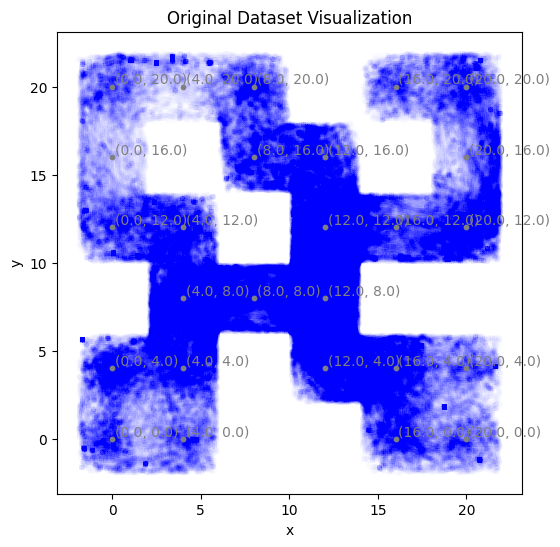

In [19]:
plt.figure(figsize=(6, 6))

plt.scatter(x=x, y=y, c='blue', s=10, alpha=0.002)
plt.scatter(x=all_cells[:, 0], y=all_cells[:, 1], s=10, c='gray', alpha=1.0)
plt.title('Original Dataset Visualization')
plt.xlabel('x')
plt.ylabel('y')

for i in range(len(all_cells)):
    plt.annotate(f'{(all_cells[i, 0], all_cells[i, 1])}', (all_cells[i, 0], all_cells[i, 1]), xytext=(2, 2), textcoords='offset points', c='gray')

plt.show()

In [20]:
def plot_heatmap(data, xlabel, ylabel, title):
    # your dict (example)
    d = data

    # --- build grid ---
    xs = np.array([x for (x, y) in d.keys()], dtype=float)
    ys = np.array([y for (x, y) in d.keys()], dtype=float)

    x_min, x_max = int(np.floor(xs.min())), int(np.ceil(xs.max()))
    y_min, y_max = int(np.floor(ys.min())), int(np.ceil(ys.max()))

    # edges for 1x1 squares: [x_min, x_min+1, ..., x_max+1]
    x_edges = np.arange(x_min, x_max + 2, 1)
    y_edges = np.arange(y_min, y_max + 2, 1)

    # cell values (ny rows by nx cols); use NaN for "missing" cells
    Z = np.full((len(y_edges) - 1, len(x_edges) - 1), np.nan, dtype=float)

    # fill Z: row index corresponds to y, col index corresponds to x
    for (x, y), val in d.items():
        i = int(round(x)) - x_min  # column
        j = int(round(y)) - y_min  # row
        Z[j, i] = val

    # --- plot ---
    fig, ax = plt.subplots(figsize=(6, 6))
    m = ax.pcolormesh(x_edges, y_edges, Z, shading="flat")  # cells are 1x1 by construction
    fig.colorbar(m, ax=ax, label="density")

    plt.scatter(x=all_cells[:, 0], y=all_cells[:, 1], s=10, c='gray', alpha=1.0)
    for i in range(len(all_cells)):
        plt.annotate(f'{(all_cells[i, 0], all_cells[i, 1])}', (all_cells[i, 0], all_cells[i, 1]), xytext=(2, 2), textcoords='offset points', c='gray')

    ax.set_aspect("equal")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    plt.show()

In [21]:
np.floor(data_100000['observations'] * 10)

array([[ 35.,  73.,   3., ...,   0.,   0.,  -1.],
       [ 35.,  73.,   2., ..., -53.,  51., 130.],
       [ 35.,  73.,   0., ..., -66., -10., -55.],
       ...,
       [ 69.,  78.,   1., ...,   5.,  40.,   0.],
       [ 70.,  77.,   1., ...,   2.,  67.,  -1.],
       [ 71.,  77.,   1., ...,  -1., 108.,  -2.]], dtype=float32)

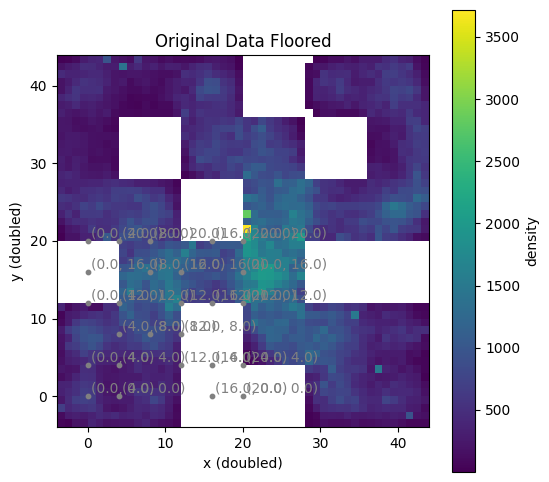

In [22]:
original_data_floored = {}
floored = np.floor(data_100000['observations'] * 2)

for i in range(len(floored)):
    rounded = (floored[i][0], floored[i][1])
    if rounded in original_data_floored:
        original_data_floored[rounded] += 1
    else:
        original_data_floored[rounded] = 1

plot_heatmap(original_data_floored, 'x (doubled)', 'y (doubled)', 'Original Data Floored')

## Evaluating Two Different Skills

In [23]:
# SKILL_1 = [(4.0, 20.0), (0.0, 16.0)]
SKILL_1 = [(0.0, 20.0), (0.0, 12.0)]
# SKILL_2 = [(8.0, 8.0), (4.0, 4.0)]
SKILL_2 = [(20.0, 20.0), (20.0, 12.0)]

In [24]:
task_1 = {
    'task_name': 'special_task1',
    'init_ij': env.unwrapped.xy_to_ij(SKILL_1[0]),
    'init_xy': SKILL_1[0],
    'goal_ij': env.unwrapped.xy_to_ij(SKILL_1[1]),
    'goal_xy': SKILL_1[1]
}

task_2 = {
    'task_name': 'special_task2',
    'init_ij': env.unwrapped.xy_to_ij(SKILL_2[0]),
    'init_xy': SKILL_2[0],
    'goal_ij': env.unwrapped.xy_to_ij(SKILL_2[1]),
    'goal_xy': SKILL_2[1]
}

special_task_infos = [task_1, task_2]

In [25]:
env.task_infos = special_task_infos

In [56]:
eval_metrics = env.evaluate_step(agent=agent, config=config)

100%|██████████| 2/2 [01:14<00:00, 37.39s/it]


In [57]:
eval_metrics

{'evaluation/special_task1_success': 0.4,
 'evaluation/special_task2_success': 0.2,
 'evaluation/overall_success': 0.30000000000000004}

In [26]:
from collections import defaultdict

import jax
import numpy as np
from tqdm import trange

from utils.evaluation import supply_rng, add_to, flatten

In [27]:
# actor_fn = supply_rng(agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32)))
# trajs = []
# stats = defaultdict(list)

# init_ij = task_1['init_ij']
# goal_ij = task_1['goal_ij']

# renders = []
# for i in trange(5):
#     traj = defaultdict(list)

#     # observation, info = env.reset(options=dict(task_id=task_id, render_goal=should_render))
#     observation, info = env.reset(options=dict(task_info=dict(init_ij=init_ij, goal_ij=goal_ij)))
#     goal = info.get('goal')
#     goal_frame = info.get('goal_rendered')
    
#     done = False
#     step = 0
#     render = []
#     while not done:
#         action = actor_fn(observations=observation, goals=goal, temperature=0.0)
# #         action = np.array(action)
# #         action = np.clip(action, -1, 1)

# #         next_observation, reward, terminated, truncated, info = env.step(action)
# #         done = terminated or truncated
# #         step += 1

# #         transition = dict(
# #             observation=observation,
# #             next_observation=next_observation,
# #             action=action,
# #             reward=reward,
# #             done=done,
# #             info=info,
# #         )
# #         add_to(traj, transition)
# #         observation = next_observation

# #     add_to(stats, flatten(info))
# #     trajs.append(traj)

# # for k, v in stats.items():
# #     stats[k] = np.mean(v)

In [28]:
config

{'lr': 0.0003,
 'tau': 0.005,
 'alpha': 300,
 'q_agg': 'mean',
 'num_qs': 10,
 'ob_dims': (69,),
 'discount': 0.995,
 'action_dim': 21,
 'actor_type': 'best-of-n',
 'agent_name': 'gcfql',
 'batch_size': 256,
 'flow_steps': 10,
 'layer_norm': True,
 'awr_invtemp': 0,
 'gc_negative': False,
 'num_actions': 8,
 'dataset_class': 'GCDataset',
 'subgoal_steps': 25,
 'actor_p_curgoal': 0,
 'value_p_curgoal': 0.2,
 'actor_p_trajgoal': 0.5,
 'critic_loss_type': 'bce',
 'value_p_trajgoal': 0.5,
 'actor_geom_sample': True,
 'actor_hidden_dims': [512, 512, 512, 512],
 'value_geom_sample': False,
 'value_hidden_dims': [512, 512, 512, 512],
 'actor_p_randomgoal': 0.5,
 'goal_proposer_type': 'awr',
 'value_p_randomgoal': 0.3,
 'train_goal_proposer': False}

In [61]:
agent.config

FrozenDict({
    lr: 0.0003,
    tau: 0.005,
    alpha: 300,
    q_agg: 'mean',
    num_qs: 10,
    ob_dims: (69,),
    discount: 0.995,
    action_dim: 21,
    actor_type: 'best-of-n',
    agent_name: 'gcfql',
    batch_size: 256,
    flow_steps: 10,
    layer_norm: True,
    awr_invtemp: 0,
    gc_negative: False,
    num_actions: 8,
    dataset_class: 'GCDataset',
    subgoal_steps: 25,
    actor_p_curgoal: 0,
    value_p_curgoal: 0.2,
    actor_p_trajgoal: 0.5,
    critic_loss_type: 'bce',
    value_p_trajgoal: 0.5,
    actor_geom_sample: True,
    actor_hidden_dims: [512, 512, 512, 512],
    value_geom_sample: False,
    value_hidden_dims: [512, 512, 512, 512],
    actor_p_randomgoal: 0.5,
    goal_proposer_type: 'awr',
    value_p_randomgoal: 0.3,
    train_goal_proposer: False,
})

In [29]:
# goal_frame

## Evaluating Reachability

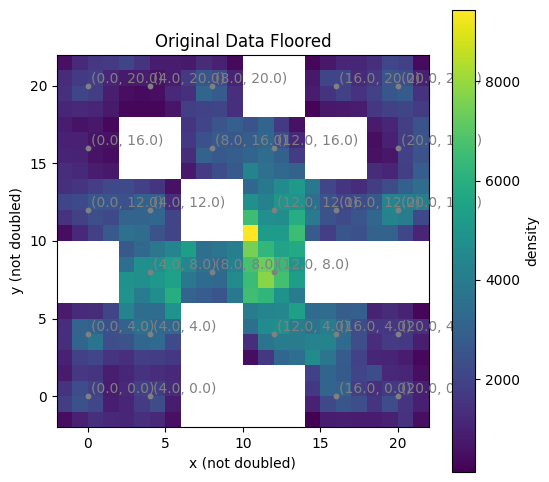

In [30]:
original_data_floored = {}
floored = np.floor(data_100000['observations'])

for i in range(len(floored)):
    rounded = (floored[i][0], floored[i][1])
    if rounded in original_data_floored:
        original_data_floored[rounded] += 1
    else:
        original_data_floored[rounded] = 1

plot_heatmap(original_data_floored, 'x (not doubled)', 'y (not doubled)', 'Original Data Floored')

In [31]:
original_data_floored.keys()

dict_keys([(3.0, 7.0), (3.0, 8.0), (3.0, 9.0), (2.0, 9.0), (2.0, 10.0), (2.0, 11.0), (1.0, 11.0), (1.0, 12.0), (0.0, 12.0), (0.0, 13.0), (-1.0, 13.0), (-2.0, 13.0), (-2.0, 12.0), (-2.0, 11.0), (-2.0, 10.0), (-1.0, 10.0), (0.0, 10.0), (0.0, 11.0), (-1.0, 11.0), (1.0, 10.0), (1.0, 13.0), (0.0, 14.0), (-1.0, 14.0), (-2.0, 14.0), (-1.0, 12.0), (1.0, 14.0), (3.0, 10.0), (4.0, 9.0), (4.0, 8.0), (5.0, 8.0), (5.0, 7.0), (5.0, 6.0), (6.0, 6.0), (4.0, 6.0), (3.0, 6.0), (3.0, 5.0), (2.0, 5.0), (2.0, 4.0), (1.0, 4.0), (1.0, 3.0), (0.0, 3.0), (0.0, 2.0), (0.0, 1.0), (-1.0, 1.0), (-1.0, 0.0), (-1.0, -1.0), (-1.0, -2.0), (0.0, -1.0), (0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (1.0, 2.0), (2.0, 3.0), (2.0, 6.0), (4.0, 10.0), (4.0, 11.0), (4.0, 12.0), (3.0, 12.0), (3.0, 13.0), (2.0, 13.0), (0.0, 15.0), (0.0, 16.0), (0.0, 17.0), (0.0, 18.0), (-1.0, 18.0), (-1.0, 19.0), (-1.0, 20.0), (-1.0, 21.0), (0.0, 21.0), (1.0, 21.0), (2.0, 21.0), (3.0, 21.0), (16.0, 4.0), (15.0, 4.0), (15.0, 3.0), (14.0, 3.0), (13.0, 3.0)

In [32]:
START_XY = (12.0, 8.0)
GOAL_XYS = list(original_data_floored.keys())
START_IJ = env.unwrapped.xy_to_ij(START_XY)

task_infos = []

for goal_xy in GOAL_XYS:
    task_info = {
        'task_name': f'{goal_xy}',
        'init_ij': START_IJ,
        'init_xy': START_XY,
        'goal_ij': env.unwrapped.xy_to_ij(goal_xy),
        'goal_xy': goal_xy
    }

    task_infos.append(task_info)

In [33]:
task_infos

[{'task_name': '(3.0, 7.0)',
  'init_ij': (3, 4),
  'init_xy': (12.0, 8.0),
  'goal_ij': (3, 2),
  'goal_xy': (3.0, 7.0)},
 {'task_name': '(3.0, 8.0)',
  'init_ij': (3, 4),
  'init_xy': (12.0, 8.0),
  'goal_ij': (3, 2),
  'goal_xy': (3.0, 8.0)},
 {'task_name': '(3.0, 9.0)',
  'init_ij': (3, 4),
  'init_xy': (12.0, 8.0),
  'goal_ij': (3, 2),
  'goal_xy': (3.0, 9.0)},
 {'task_name': '(2.0, 9.0)',
  'init_ij': (3, 4),
  'init_xy': (12.0, 8.0),
  'goal_ij': (3, 2),
  'goal_xy': (2.0, 9.0)},
 {'task_name': '(2.0, 10.0)',
  'init_ij': (3, 4),
  'init_xy': (12.0, 8.0),
  'goal_ij': (4, 2),
  'goal_xy': (2.0, 10.0)},
 {'task_name': '(2.0, 11.0)',
  'init_ij': (3, 4),
  'init_xy': (12.0, 8.0),
  'goal_ij': (4, 2),
  'goal_xy': (2.0, 11.0)},
 {'task_name': '(1.0, 11.0)',
  'init_ij': (3, 4),
  'init_xy': (12.0, 8.0),
  'goal_ij': (4, 1),
  'goal_xy': (1.0, 11.0)},
 {'task_name': '(1.0, 12.0)',
  'init_ij': (3, 4),
  'init_xy': (12.0, 8.0),
  'goal_ij': (4, 1),
  'goal_xy': (1.0, 12.0)},
 {'task_

In [67]:
env.task_infos = task_infos
eval_metrics = env.evaluate_step(agent=agent, config=config, eval_episodes=3)

100%|██████████| 416/416 [1:22:09<00:00, 11.85s/it]


In [68]:
eval_metrics

{'evaluation/(3.0, 7.0)_success': 0.3333333333333333,
 'evaluation/(3.0, 8.0)_success': 0.6666666666666666,
 'evaluation/(3.0, 9.0)_success': 0.0,
 'evaluation/(2.0, 9.0)_success': 0.0,
 'evaluation/(2.0, 10.0)_success': 0.3333333333333333,
 'evaluation/(2.0, 11.0)_success': 0.0,
 'evaluation/(1.0, 11.0)_success': 0.0,
 'evaluation/(1.0, 12.0)_success': 0.3333333333333333,
 'evaluation/(0.0, 12.0)_success': 0.0,
 'evaluation/(0.0, 13.0)_success': 0.0,
 'evaluation/(-1.0, 13.0)_success': 0.0,
 'evaluation/(-2.0, 13.0)_success': 0.3333333333333333,
 'evaluation/(-2.0, 12.0)_success': 0.3333333333333333,
 'evaluation/(-2.0, 11.0)_success': 0.0,
 'evaluation/(-2.0, 10.0)_success': 0.0,
 'evaluation/(-1.0, 10.0)_success': 0.6666666666666666,
 'evaluation/(0.0, 10.0)_success': 0.6666666666666666,
 'evaluation/(0.0, 11.0)_success': 0.0,
 'evaluation/(-1.0, 11.0)_success': 0.3333333333333333,
 'evaluation/(1.0, 10.0)_success': 0.0,
 'evaluation/(1.0, 13.0)_success': 0.0,
 'evaluation/(0.0, 14.

In [73]:
success_data_dict = {}

for k, v in eval_metrics.items():
    goal_xy = k[11:]
    goal_xy = goal_xy[: -8]
    if goal_xy != 'overall':
        goal_xy = eval(goal_xy)
        success_data_dict[goal_xy] = v

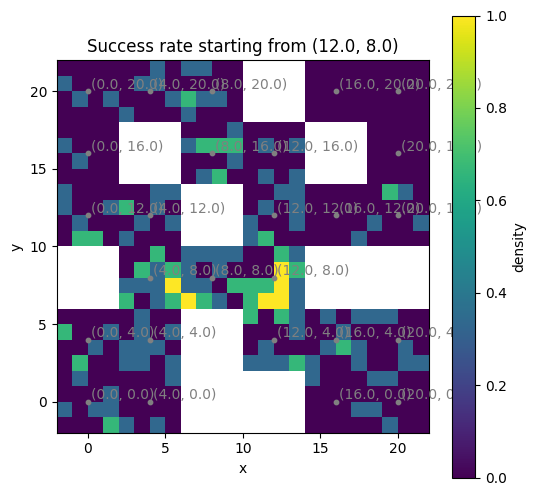

In [75]:
plot_heatmap(success_data_dict, 'x', 'y', 'Success rate starting from (12.0, 8.0)')

In [ ]:
# {'evaluation/special_task1_success': 0.4,
#  'evaluation/special_task2_success': 0.3,
#  'evaluation/overall_success': 0.35}

## Starting from Another Position (4.0, 20.0)

In [76]:
START_XY = (4.0, 20.0)
GOAL_XYS = list(original_data_floored.keys())
START_IJ = env.unwrapped.xy_to_ij(START_XY)

task_infos = []

for goal_xy in GOAL_XYS:
    task_info = {
        'task_name': f'{goal_xy}',
        'init_ij': START_IJ,
        'init_xy': START_XY,
        'goal_ij': env.unwrapped.xy_to_ij(goal_xy),
        'goal_xy': goal_xy
    }

    task_infos.append(task_info)

In [77]:
env.task_infos = task_infos
eval_metrics = env.evaluate_step(agent=agent, config=config, eval_episodes=3)

100%|██████████| 416/416 [1:21:00<00:00, 11.68s/it]


In [79]:
eval_metrics

{'evaluation/(3.0, 7.0)_success': 0.3333333333333333,
 'evaluation/(3.0, 8.0)_success': 0.6666666666666666,
 'evaluation/(3.0, 9.0)_success': 0.6666666666666666,
 'evaluation/(2.0, 9.0)_success': 0.0,
 'evaluation/(2.0, 10.0)_success': 0.6666666666666666,
 'evaluation/(2.0, 11.0)_success': 0.0,
 'evaluation/(1.0, 11.0)_success': 0.0,
 'evaluation/(1.0, 12.0)_success': 0.0,
 'evaluation/(0.0, 12.0)_success': 0.0,
 'evaluation/(0.0, 13.0)_success': 0.0,
 'evaluation/(-1.0, 13.0)_success': 0.6666666666666666,
 'evaluation/(-2.0, 13.0)_success': 0.3333333333333333,
 'evaluation/(-2.0, 12.0)_success': 0.6666666666666666,
 'evaluation/(-2.0, 11.0)_success': 0.3333333333333333,
 'evaluation/(-2.0, 10.0)_success': 0.0,
 'evaluation/(-1.0, 10.0)_success': 0.6666666666666666,
 'evaluation/(0.0, 10.0)_success': 0.6666666666666666,
 'evaluation/(0.0, 11.0)_success': 0.0,
 'evaluation/(-1.0, 11.0)_success': 0.3333333333333333,
 'evaluation/(1.0, 10.0)_success': 0.3333333333333333,
 'evaluation/(1.0

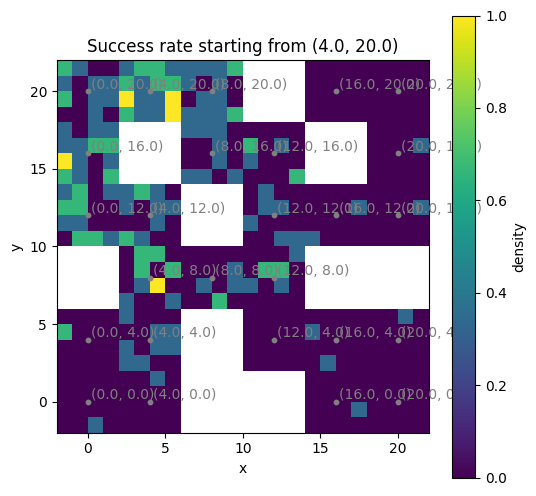

In [78]:
success_data_dict = {}

for k, v in eval_metrics.items():
    goal_xy = k[11:]
    goal_xy = goal_xy[: -8]
    if goal_xy != 'overall':
        goal_xy = eval(goal_xy)
        success_data_dict[goal_xy] = v

plot_heatmap(success_data_dict, 'x', 'y', 'Success rate starting from (4.0, 20.0)')

## Starting from Another Position (16.0, 20.0)

In [34]:
START_XY = (16.0, 20.0)
GOAL_XYS = list(original_data_floored.keys())
START_IJ = env.unwrapped.xy_to_ij(START_XY)

task_infos = []

for goal_xy in GOAL_XYS:
    task_info = {
        'task_name': f'{goal_xy}',
        'init_ij': START_IJ,
        'init_xy': START_XY,
        'goal_ij': env.unwrapped.xy_to_ij(goal_xy),
        'goal_xy': goal_xy
    }

    task_infos.append(task_info)

In [ ]:
env.task_infos = task_infos
eval_metrics, all_trajs = env.evaluate_step(agent=agent, config=config, eval_episodes=3, return_trajs=True)

 12%|█▏        | 48/416 [10:40<1:23:42, 13.65s/it]